#### Adamantios Zaras AM: 06
#### Panagiotis Souranis AM: 17

# Description

In this part of the project, we used 3 different cost-sensitive learning techniques in the Data Mining Cup Dataset, combined with 3 different learning algoriths and compared them with simple usage of the classifiers, thus not taking into consideration the classification cost.  

The techniques we used are:
- Sigmoid Probability Calibration
- Undersampling of the less important class, followed by oversampling of the important one.
- Example weighting.  

The algorithms we combined with the above techniques are:
- Random Forest
- Linear SVM
- Naive Bayes

# Global

### Package Installation

In [0]:
!pip install git+git://github.com/albahnsen/CostSensitiveClassification.git

### Imports

In [0]:
import io
import time

import requests
import numpy as np
import scipy
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from costcla.models import BayesMinimumRiskClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Import utils functions for cost sensitive learning.
from utils import report, full_cs_report

%matplotlib inline

### Prepare Dataset

In [0]:
# Read the dataset.
url="http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/heart/heart.dat"
s=requests.get(url).content
dataset=read_csv(io.StringIO(s.decode('utf-8')), sep=' ')

# Get x and y.
X, y = dataset.iloc[:, :-1].values, dataset.iloc[:, -1].values

# Convert labels from 1, 2 to 0, 1.
y[y == 1] = 0
y[y == 2] = 1

# Create class names.
labels = ['Absence', 'Presence']

# Split to training and test pairs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)

# Scale data.
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.fit_transform(X_test.astype(float))

# Define the cost matrix.
# _________  absence  presence
# absence    0        1
# presence   5        0 
fp = np.full((y_test.shape[0], 1), 5)
fn = np.full((y_test.shape[0], 1), 1)
tp = np.zeros((y_test.shape[0], 1))
tn = np.zeros((y_test.shape[0], 1))
cost_matrix = np.hstack((fp, fn, tp, tn))

### Define classifiers

In [0]:
# Random Forest
forest = RandomForestClassifier(random_state=0, n_jobs=-1)

# Linear SVM
svm = LinearSVC(random_state=0)

# Naive Bayes
bayes = MultinomialNB()

# Hyperparameters Tuning

### Random Forest Tuning

#### Random Search
Run a Random Search using 10 fold cross validation.

In [0]:
# Specify parameters and distributions to sample from 
param_dist = {'max_depth': scipy.stats.randint(1, 30),
              'max_features': scipy.stats.randint(1, X.shape[1]),
              'min_samples_split': scipy.stats.randint(2, X.shape[0] / 2),
              'n_estimators': scipy.stats.randint(10, 600),
              'criterion': ['gini', 'entropy']}
# Specify number of random candidates to be created.
candidates = 200

# Run a random search CV.
random_search = RandomizedSearchCV(forest, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 10.2min


RandomizedSearchCV took 691.00 seconds for 200 candidates.
Model with rank: 1
Mean validation score: 0.840 (std: 0.058)
Parameters: {'criterion': 'gini', 'max_depth': 15, 'max_features': 1, 'min_samples_split': 19, 'n_estimators': 103}

Model with rank: 2
Mean validation score: 0.835 (std: 0.069)
Parameters: {'criterion': 'gini', 'max_depth': 14, 'max_features': 2, 'min_samples_split': 37, 'n_estimators': 557}

Model with rank: 2
Mean validation score: 0.835 (std: 0.070)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 3, 'min_samples_split': 50, 'n_estimators': 18}

Model with rank: 2
Mean validation score: 0.835 (std: 0.062)
Parameters: {'criterion': 'entropy', 'max_depth': 17, 'max_features': 1, 'min_samples_split': 33, 'n_estimators': 339}

Model with rank: 2
Mean validation score: 0.835 (std: 0.069)
Parameters: {'criterion': 'entropy', 'max_depth': 25, 'max_features': 2, 'min_samples_split': 38, 'n_estimators': 486}

Model with rank: 2
Mean validation score: 0.

[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 11.5min finished


#### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(14, 16),
              'max_features': range(1, 3),
              'min_samples_split': range(18, 20),
              'n_estimators': range(100, 105),
              'criterion': ['gini', 'entropy']}

# Run a grid search CV.
grid_search = GridSearchCV(forest, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  2.0min


GridSearchCV took 146.33 seconds.
Model with rank: 1
Mean validation score: 0.846 (std: 0.058)
Parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 1, 'min_samples_split': 19, 'n_estimators': 101}

Model with rank: 1
Mean validation score: 0.846 (std: 0.058)
Parameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 1, 'min_samples_split': 19, 'n_estimators': 101}

Model with rank: 3
Mean validation score: 0.840 (std: 0.058)
Parameters: {'criterion': 'gini', 'max_depth': 14, 'max_features': 1, 'min_samples_split': 19, 'n_estimators': 103}

Model with rank: 3
Mean validation score: 0.840 (std: 0.058)
Parameters: {'criterion': 'gini', 'max_depth': 14, 'max_features': 1, 'min_samples_split': 19, 'n_estimators': 104}

Model with rank: 3
Mean validation score: 0.840 (std: 0.083)
Parameters: {'criterion': 'gini', 'max_depth': 14, 'max_features': 2, 'min_samples_split': 19, 'n_estimators': 101}

Model with rank: 3
Mean validation score: 0.840 (std: 0.085)
Parameter

[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  2.4min finished


#### Use best hyperparameters.

In [0]:
forest.max_depth = 14
forest.max_features = 1
forest.min_samples_split = 19
forest.n_estimators = 101
forest.criterion = 'entropy'

### SVM Tuning

#### Grid Search
Run a Grid search, using 10 fold cross validation.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'C': np.arange(0.01, 1000, 0.5)}

# Run a grid search CV.
grid_search = GridSearchCV(svm, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 2000 candidates, totalling 20000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 604 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 3844 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 9244 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 16804 tasks      | elapsed:  2.1min


GridSearchCV took 147.67 seconds.
Model with rank: 1
Mean validation score: 0.840 (std: 0.075)
Parameters: {'C': 1.51}

Model with rank: 1
Mean validation score: 0.840 (std: 0.075)
Parameters: {'C': 2.01}

Model with rank: 1
Mean validation score: 0.840 (std: 0.072)
Parameters: {'C': 4.01}

Model with rank: 1
Mean validation score: 0.840 (std: 0.072)
Parameters: {'C': 4.51}

Model with rank: 1
Mean validation score: 0.840 (std: 0.072)
Parameters: {'C': 5.01}

Model with rank: 1
Mean validation score: 0.840 (std: 0.072)
Parameters: {'C': 5.51}

Model with rank: 1
Mean validation score: 0.840 (std: 0.072)
Parameters: {'C': 6.01}

Model with rank: 1
Mean validation score: 0.840 (std: 0.072)
Parameters: {'C': 6.51}

Model with rank: 1
Mean validation score: 0.840 (std: 0.072)
Parameters: {'C': 7.01}

Model with rank: 1
Mean validation score: 0.840 (std: 0.072)
Parameters: {'C': 7.51}

Model with rank: 1
Mean validation score: 0.840 (std: 0.072)
Parameters: {'C': 8.01}

Model with rank: 1
M

[Parallel(n_jobs=-1)]: Done 20000 out of 20000 | elapsed:  2.5min finished


#### Use the best C.

In [0]:
# Change C.
svm.C = 31

# Increase number of iterations.
svm.max_iter = 20000

### Naive Bayes Tuning

#### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'alpha': np.arange(0, 10, 0.2)}

# Run a grid search CV.
grid_search = GridSearchCV(bayes, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


GridSearchCV took 0.72 seconds.
Model with rank: 1
Mean validation score: 0.835 (std: 0.055)
Parameters: {'alpha': 1.2000000000000002}

Model with rank: 1
Mean validation score: 0.835 (std: 0.055)
Parameters: {'alpha': 1.4000000000000001}

Model with rank: 1
Mean validation score: 0.835 (std: 0.055)
Parameters: {'alpha': 1.6}

Model with rank: 1
Mean validation score: 0.835 (std: 0.055)
Parameters: {'alpha': 1.8}

Model with rank: 1
Mean validation score: 0.835 (std: 0.055)
Parameters: {'alpha': 2.0}

Model with rank: 1
Mean validation score: 0.835 (std: 0.055)
Parameters: {'alpha': 2.2}



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


#### Use the best alpha.

In [0]:
bayes.alpha = 1.2


# No Method Applied

Random Forest: 

              precision    recall  f1-score   support

     Absence       0.83      0.88      0.85        43
    Presence       0.86      0.79      0.82        38

   micro avg       0.84      0.84      0.84        81
   macro avg       0.84      0.84      0.84        81
weighted avg       0.84      0.84      0.84        81



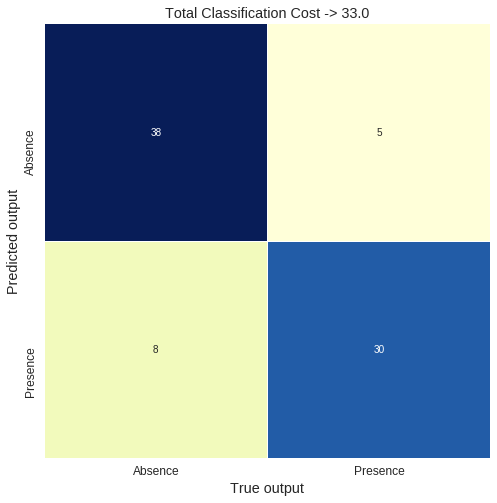


---------------------------------------------------------------

SVM: 

              precision    recall  f1-score   support

     Absence       0.83      0.79      0.81        43
    Presence       0.78      0.82      0.79        38

   micro avg       0.80      0.80      0.80        81
   macro avg       0.80      0.80      0.80        81
weighted avg       0.80      0.80      0.80        81



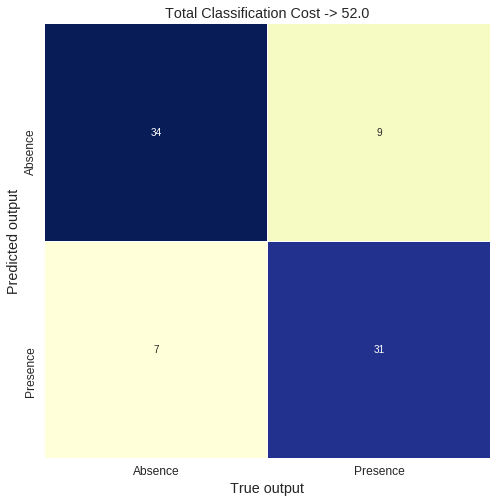


---------------------------------------------------------------

Bayes: 

              precision    recall  f1-score   support

     Absence       0.79      0.88      0.84        43
    Presence       0.85      0.74      0.79        38

   micro avg       0.81      0.81      0.81        81
   macro avg       0.82      0.81      0.81        81
weighted avg       0.82      0.81      0.81        81



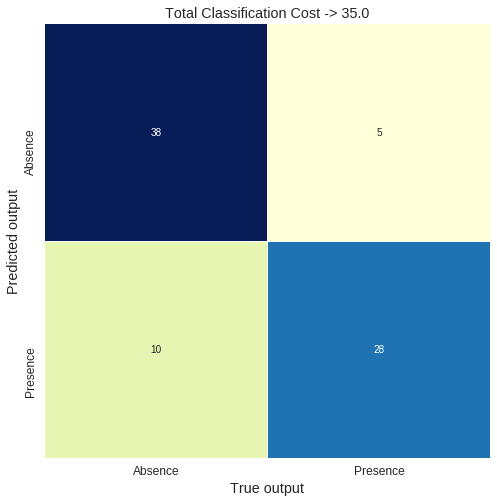

In [20]:
def simple_predict(clf):
    """
    Predicts without using any cost sensitive method, provided a given classifier.
    
    :param clf: the classifier to make prediction with.
    """
    clf.fit(X_train, y_train)
    return clf.predict(X_test)

# Make a full report for all the classifiers.
full_cs_report(y_test, 
               simple_predict(forest),
               simple_predict(svm),
               simple_predict(bayes),
               labels, cost_matrix)

We noticed that the F1 score is good, but the classification cost is high. For that reason, we need to "tell" our model to be more careful about false positives.

# Sigmoid Probability Calibration

Random Forest: 

              precision    recall  f1-score   support

     Absence       0.61      1.00      0.75        43
    Presence       1.00      0.26      0.42        38

   micro avg       0.65      0.65      0.65        81
   macro avg       0.80      0.63      0.59        81
weighted avg       0.79      0.65      0.60        81



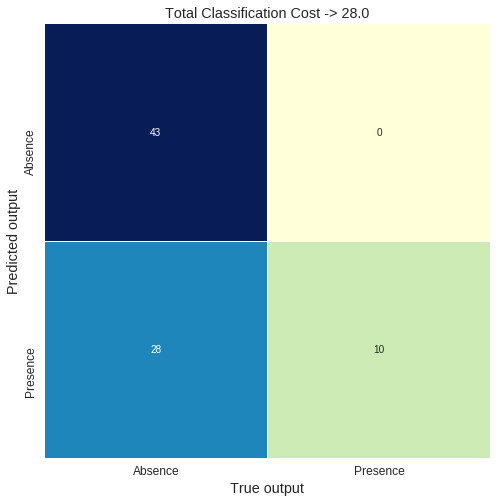


---------------------------------------------------------------

SVM: 

              precision    recall  f1-score   support

     Absence       0.67      1.00      0.80        43
    Presence       1.00      0.45      0.62        38

   micro avg       0.74      0.74      0.74        81
   macro avg       0.84      0.72      0.71        81
weighted avg       0.83      0.74      0.72        81



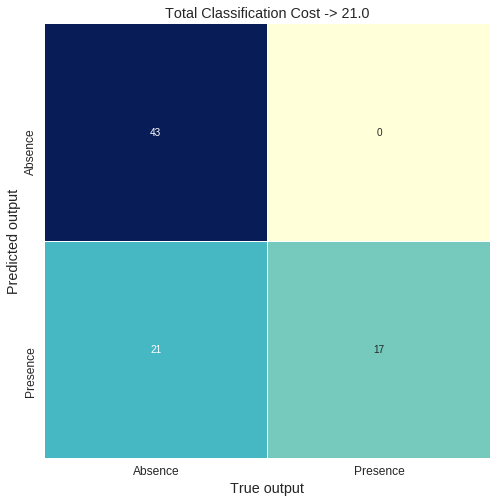


---------------------------------------------------------------

Bayes: 

              precision    recall  f1-score   support

     Absence       0.58      1.00      0.74        43
    Presence       1.00      0.18      0.31        38

   micro avg       0.62      0.62      0.62        81
   macro avg       0.79      0.59      0.52        81
weighted avg       0.78      0.62      0.54        81



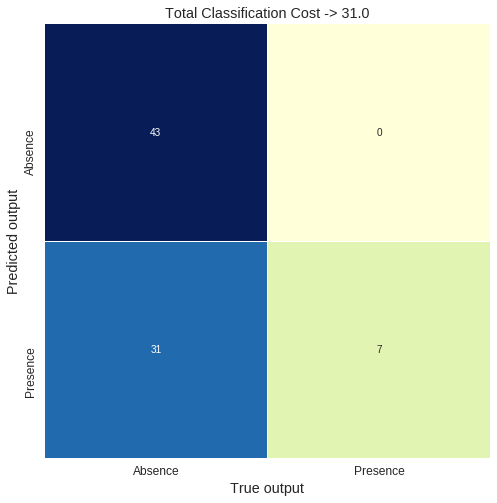

In [26]:
def calibration_predict(clf):
    """
    Predicts using sigmoid probability calibration with a given classifier.
    """
    cc = CalibratedClassifierCV(clf, method='sigmoid', cv=10)
    model = cc.fit(X_train, y_train)
    prob_test = model.predict_proba(X_test)
    bmr = BayesMinimumRiskClassifier(calibration=False)
    
    return bmr.predict(prob_test, cost_matrix)

# Make a full report for all the classifiers.
full_cs_report(y_test, 
               calibration_predict(forest),
               calibration_predict(svm),
               calibration_predict(bayes),
               labels, cost_matrix)

We noticed that the model chooses the class **'Presence'** more often, in order to avoid making mistakes that cost a lot.  
Moreover, the F1 score reduced, but this is not what we should try to improve. The total cost is the most important metric for this task.

# Rebalancing

/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (350) in class 0 will be larger than the number of samples in the majority class (class #0 -> 100)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (350) in class 0 will be larger than the number of samples in the majority class (class #0 -> 100)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (350) in class 0 will be larger than the number of samples in the majority class (class #0 -> 100)
  n_samples_majority))


Random Forest: 

              precision    recall  f1-score   support

     Absence       0.67      1.00      0.80        43
    Presence       1.00      0.45      0.62        38

   micro avg       0.74      0.74      0.74        81
   macro avg       0.84      0.72      0.71        81
weighted avg       0.83      0.74      0.72        81



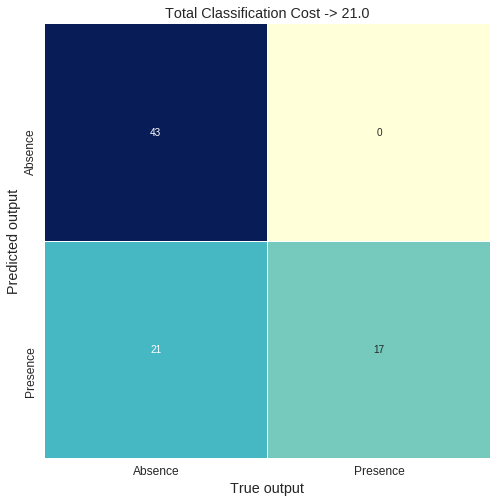


---------------------------------------------------------------

SVM: 

              precision    recall  f1-score   support

     Absence       0.80      0.93      0.86        43
    Presence       0.90      0.74      0.81        38

   micro avg       0.84      0.84      0.84        81
   macro avg       0.85      0.83      0.84        81
weighted avg       0.85      0.84      0.84        81



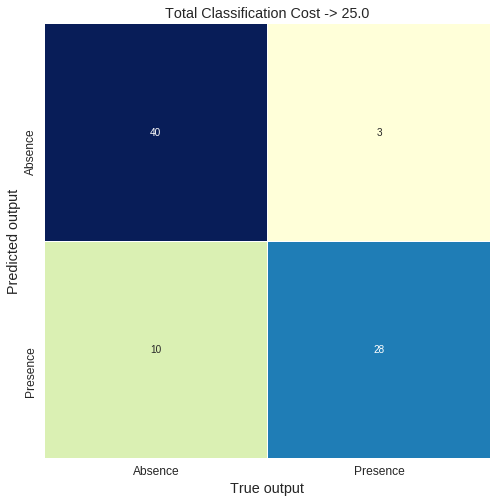


---------------------------------------------------------------

Bayes: 

              precision    recall  f1-score   support

     Absence       0.56      1.00      0.72        43
    Presence       1.00      0.11      0.19        38

   micro avg       0.58      0.58      0.58        81
   macro avg       0.78      0.55      0.45        81
weighted avg       0.77      0.58      0.47        81



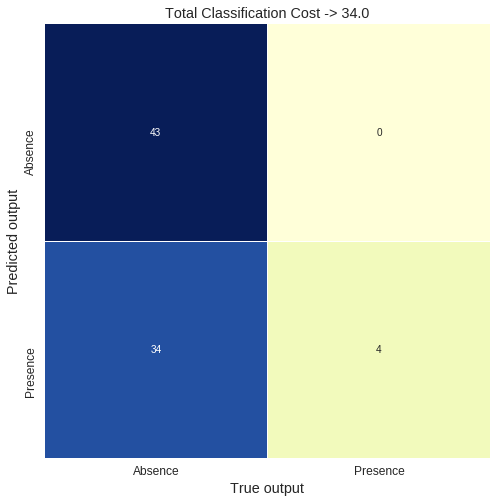

In [11]:
def rebalancing_predict(clf):
    """
    Predicts using random underampling and random oversampling with a given classifier.
    """
    # Undersample.
    sampler = RandomUnderSampler(sampling_strategy={0: 100, 1: 70}, random_state=0)
    X_rs, y_rs = sampler.fit_sample(X_train, y_train)
    # Oversample.
    sampler = RandomOverSampler(sampling_strategy={0: 350, 1: 70}, random_state=0)
    X_rs, y_rs = sampler.fit_sample(X_rs, y_rs)
    
    # Fit classifier with the undersampled data.
    clf.fit(X_rs, y_rs)
    
    # Return predictions.
    return clf.predict(X_test)

# Make a full report for all the classifiers.
full_cs_report(y_test, 
               rebalancing_predict(forest),
               rebalancing_predict(svm),
               rebalancing_predict(bayes),
               labels, cost_matrix)

Rebalancing worked better for Random Forest, but not for the other classifiers.

# Example Weighting

Random Forest: 

              precision    recall  f1-score   support

     Absence       0.66      1.00      0.80        43
    Presence       1.00      0.42      0.59        38

   micro avg       0.73      0.73      0.73        81
   macro avg       0.83      0.71      0.69        81
weighted avg       0.82      0.73      0.70        81



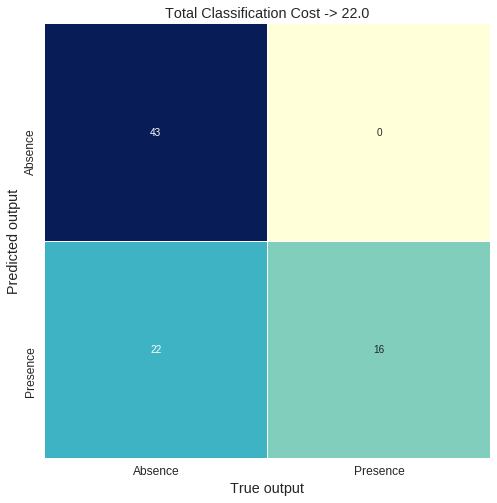


---------------------------------------------------------------

SVM: 

              precision    recall  f1-score   support

     Absence       0.83      0.79      0.81        43
    Presence       0.78      0.82      0.79        38

   micro avg       0.80      0.80      0.80        81
   macro avg       0.80      0.80      0.80        81
weighted avg       0.80      0.80      0.80        81



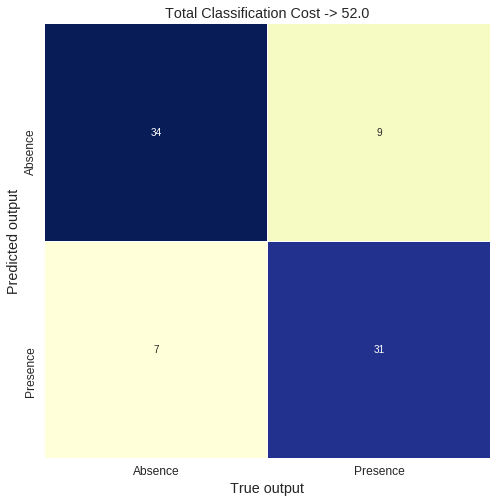


---------------------------------------------------------------

Bayes: 

              precision    recall  f1-score   support

     Absence       0.54      1.00      0.70        43
    Presence       1.00      0.05      0.10        38

   micro avg       0.56      0.56      0.56        81
   macro avg       0.77      0.53      0.40        81
weighted avg       0.76      0.56      0.42        81



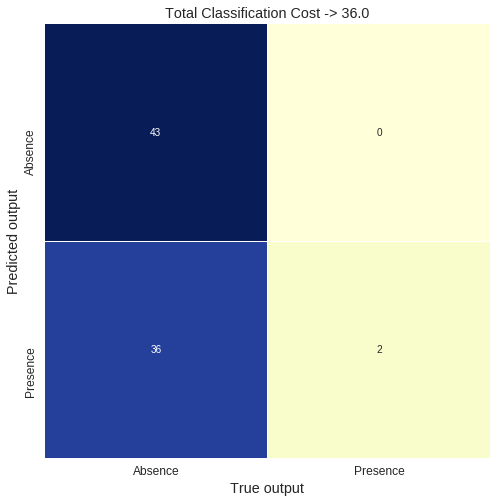

In [17]:
def weighting_predict(clf):
    """
    Predicts using sample weighting with a given classifier.
    """
    # Create the sample weights according to labels.
    weights = np.zeros(y_train.shape[0])
    weights[np.where(y_train == 1)] = 1
    weights[np.where(y_train == 0)] = 5

    # Fit classifier using the weights.
    clf.fit(X_train, y_train, weights)
    
    # Return predictions.
    return clf.predict(X_test)

# Make a full report for all the classifiers.
full_cs_report(y_test, 
               weighting_predict(forest),
               weighting_predict(svm),
               weighting_predict(bayes),
               labels, cost_matrix)

Example weighting works well for Random Forest, but produces very bad results for the others.

# Conclusion

The Example Weighting method is not stable for this task because it creates big differences among the models prediction costs, thus introducing variance.  
The most important metric is the total cost, since when using the F1, precision and Recall, the importance of some types of misclassifications is not taken into consideration.